In [8]:
#spacy english en_core_web_trf

#Librerias a usar

#from bert_serving.client import BertClient
import spacy
#from spacy.pipeline import TextRankFactory
import pytextrank

from collections import Counter
import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tag import pos_tag
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')


from rake_nltk import Rake

#import torch; print(torch.__version__)
import torch
from keybert import KeyBERT

from copy import deepcopy

[nltk_data] Downloading package punkt to
[nltk_data]     /home/alvaromontero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alvaromontero/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [46]:
#Cargar libros
Book_list=["/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/divine_comedy.txt",'/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Oddysey.txt'
           ,'/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Illiad.txt','/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Great_Gatsby.txt','/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Tom_Sawyer.txt','/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/Wuthering_Heights.txt']
#Book_list=[r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\divine_comedy.txt",r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Oddysey.txt",r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Illiad.txt",
#                r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Great_Gatsby.txt",r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Tom_Sawyer.txt",r"C:\Users\diavl\OneDrive\Escritorio\Repositorios\Tecnologias_de_lenguaje_natural\P2\Practica3\Wuthering_Heights.txt"]

Books_raw_file=[]
for i in range(len(Book_list)):
    with open(Book_list[i],'r',encoding='utf-8')as f:
        file=f.read()
        Books_raw_file.append(file)
        
        


Exploración de los textos

In [26]:
nlp=spacy.load('en_core_web_trf')
histograms=[]
for i,book in enumerate(Books_raw_file):
    #doc=nlp(book)
    tokens=word_tokenize(book,language='english')
    histograms.append(tokens.copy())
    print(f"Libro {i} {len(tokens)} tokens")

Libro 0 140726 tokens
Libro 1 144806 tokens
Libro 2 217128 tokens
Libro 3 60523 tokens
Libro 4 87625 tokens
Libro 5 145077 tokens


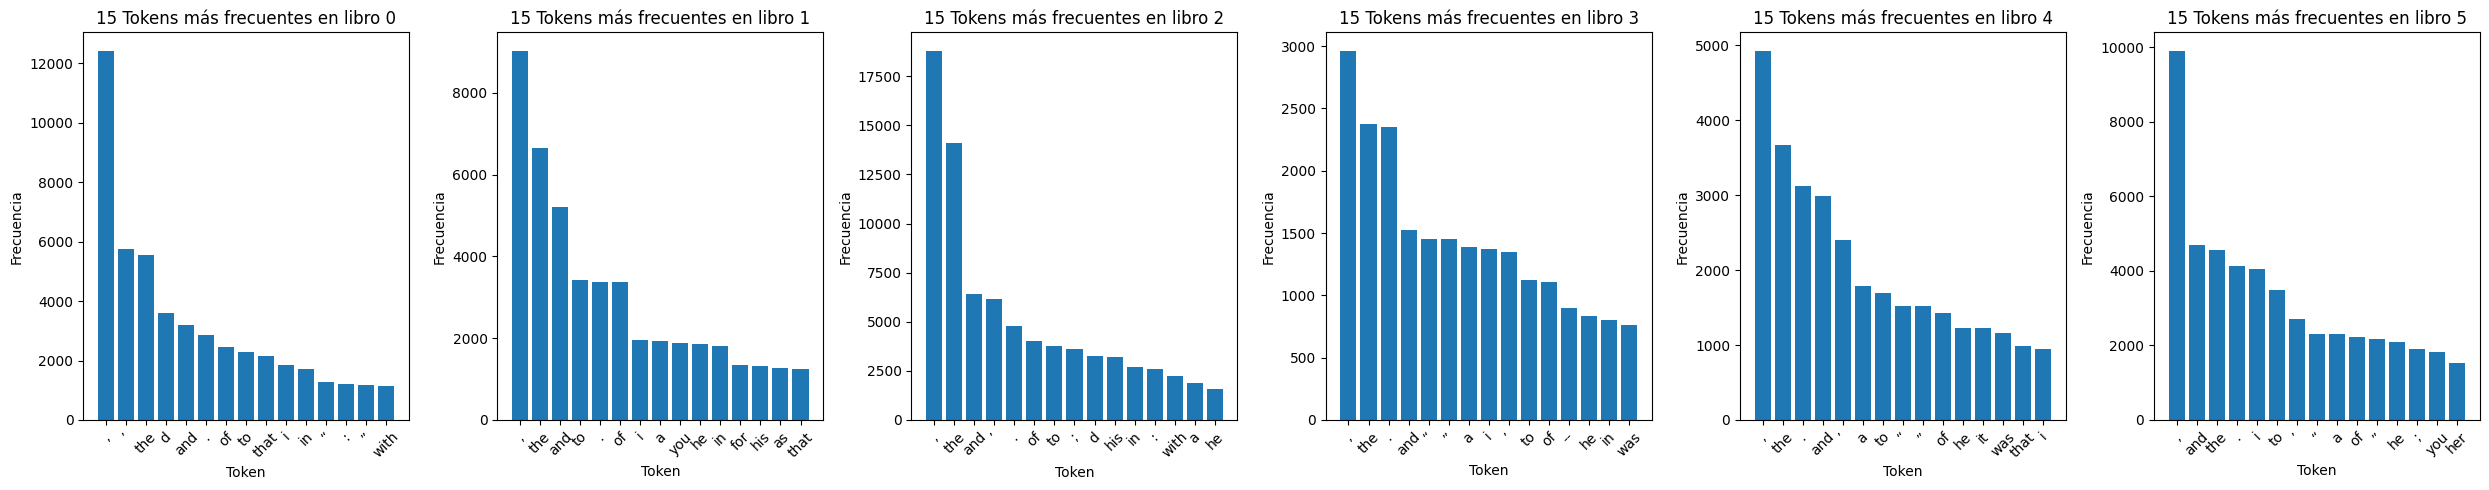

In [30]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, len(histograms), figsize=(25, 5))  # 

for i, histogram in enumerate(histograms):
    tokens_freq = Counter(histogram) #Contador de frecuencia de tokens
    #unique_tokens = [token for token, freq in tokens_freq.items() if freq == 1]
    ordered_tokens = tokens_freq.most_common(15)
    tokens_graph = [token[0] for token in ordered_tokens]
    token_freq = [token[1] for token in ordered_tokens]

    axs[i].bar(tokens_graph, token_freq)
    axs[i].set_title(f'15 Tokens más frecuentes en libro {i}')
    axs[i].set_xlabel('Token')
    axs[i].set_ylabel('Frecuencia')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Ajusta el espaciado entre subplots para que no se superpongan
plt.show()


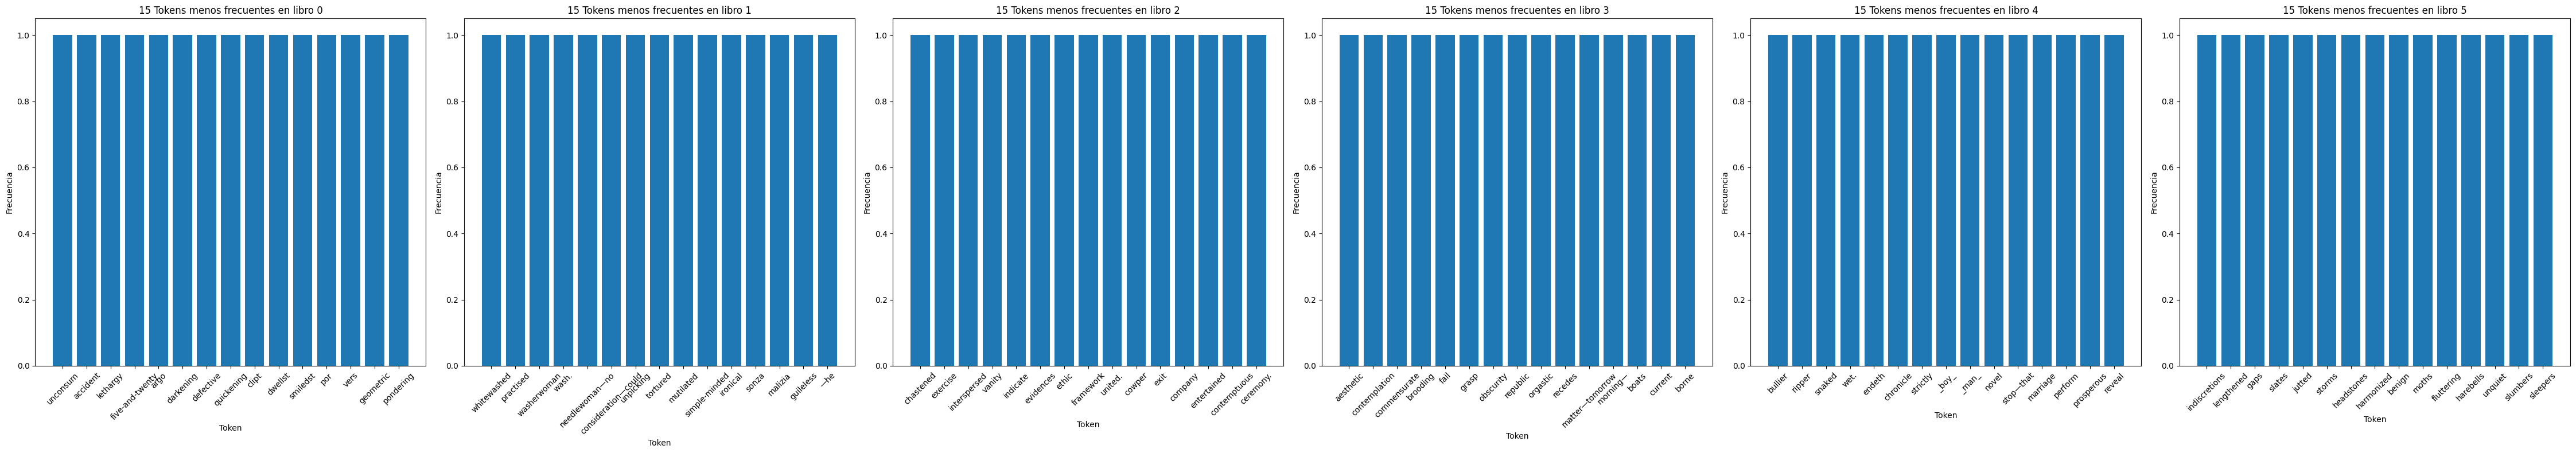

In [39]:
#Tokens menos comunes
fig, axs = plt.subplots(1, len(histograms), figsize=(45, 8)) 
for i, histogram in enumerate(histograms):
    tokens_freq = Counter(histogram) #Contador de frecuencia de tokens
    #unique_tokens = [token for token, freq in tokens_freq.items() if freq == 1]
    ordered_tokens = tokens_freq.most_common()
    ordered_tokens=ordered_tokens[-15:]
    tokens_graph = [token[0] for token in ordered_tokens]
    token_freq = [token[1] for token in ordered_tokens]

    axs[i].bar(tokens_graph, token_freq)
    axs[i].set_title(f'15 Tokens menos frecuentes en libro {i}')
    axs[i].set_xlabel('Token')
    axs[i].set_ylabel('Frecuencia')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()  # Ajusta el espaciado entre subplots para que no se superpongan
plt.show()

PREPROCESAMIENTO


In [4]:
#Funciones

def eliminar_etiquetas(text):
    pattern = re.compile(r'<[^>]+>|\([^)]+\)|--[^\-]+--')
    doc = pattern.sub('', text)
    return doc

# Removemos apostrofes para quedarnos con palabras como cant couldnt o dont
def remover_apostrofes(text):
    pattern = r"\\?'"
    doc = re.sub(pattern, '', text)
    return doc
# Nos quedamos con solo alfabeto eliminando caracteres especiales    
def remover_especiales(text):
    pattern = r"[^a-z\s]"
    doc = re.sub(pattern, ' ', text)
    return doc
# Quitamos dobles espacios para tener texto espaciado solamente por un espacio por palabra
def dobles_espacios(text):
    pattern = r'\s+'
    doc = re.sub(pattern, ' ', text)
    return doc
def remove_stopwords(text):
    words = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word not in stop_words]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

In [5]:
#Vectorizacion tfidf
def vectorizar_tfidf(corpus):
    # TF-IDF
    vectorizer = TfidfVectorizer(ngram_range=(4,4))
    tfidf_matrix = vectorizer.fit_transform(corpus)
    
    # palabras únicas
    feature_names_tfidf = vectorizer.get_feature_names_out()
    vocabulary = vectorizer.get_feature_names_out()
    print("Tamaño de Palabras únicas:", len(feature_names_tfidf))
    return tfidf_matrix,vocabulary

In [47]:
#Quitar inicio de texto
deleted_lines_list=[134,336,1997,32,459,7]

for i,book in enumerate(Books_raw_file):
    lines = book.splitlines()  # Split the book text into lines
    modified_lines = lines[deleted_lines_list[i]:]  # Keep lines starting from the specified index
    modified_book = "\n".join(modified_lines)  # Join the remaining lines back into a string
    Books_raw_file[i]=modified_book
    tokens=word_tokenize(modified_book,language='english')
    #histograms.append(tokens.copy())
    print(f"Libro {i} {len(tokens)} tokens")


Libro 0 140735 tokens
Libro 1 144823 tokens
Libro 2 217152 tokens
Libro 3 60526 tokens
Libro 4 87627 tokens
Libro 5 145084 tokens


In [48]:
for i,book in enumerate(Books_raw_file):
    Books_raw_file[i]=book.lower()
    
print(Books_raw_file[0][:200])

canto i


in the midway of this our mortal life,
i found me in a gloomy wood, astray
gone from the path direct: and e’en to tell
it were no easy task, how savage wild
that forest, how robust and rough


Eliminacion de caracteres no importantes


In [49]:

books_clean_files=[]
books_clean_stops_file=[]
for i,book in enumerate(Books_raw_file):
    Text_aux=eliminar_etiquetas(book)
    Text_aux=remover_apostrofes(Text_aux)
    Text_aux=dobles_espacios(Text_aux)
    Text_aux=remover_especiales(Text_aux)
    
    books_clean_stops_file.append(deepcopy(Text_aux))#Por si el modelo no necesita quitar stopwords
    
    Text_aux=remove_stopwords(Text_aux)
    books_clean_files.append(Text_aux)#Texto sin stopwords
    print(Text_aux[:65]+'\n')

canto midway mortal life found gloomy wood astray gone path direc

book gods council minerva visit ithaca challenge telemachus suito

iliad book argument contention achilles agamemnon war troy greeks

younger vulnerable years father gave advice turning mind ever sin

chapter tom answer tom answer gone boy wonder tom answer old lady

chapter returned visit landlord solitary neighbour shall troubled



Extracción de oraciones clave

1) TF-IDF

In [50]:
#TF-IDF NLTK

for book in books_clean_files:#Iteramos sobre los libros para obtener lo mas representativo de cada texto
    #tokens=word_tokenize(book)
    #postags=pos_tag(tokens)
    #stemmer=PorterStemmer()
    #stemmed_tokens=[stemmer.stem(token) for token in tokens]
    
    
    vectorizer = TfidfVectorizer(ngram_range=(2,4))#Vectorizador con 4 gramas
    tfidf_matrix = vectorizer.fit_transform([book])
    feature_names_tfidf = vectorizer.get_feature_names_out()
    vocabulary = vectorizer.get_feature_names_out()#Obtenemos el bocabulario
    print("Tamaño de Palabras únicas:", len(feature_names_tfidf))
    frecuencia_total = Counter()
    for ngrama in vocabulary:#Contamos las frases mas comunes
    # Obtiene el índice de la palabra en el vocabulario
        indice = vectorizer.vocabulary_[ngrama]
        # Suma las frecuencias de esa palabra en todas las frases
        frecuencia_total[ngrama] = tfidf_matrix[:, indice].sum()
    frases_mas_frecuentes = frecuencia_total.most_common(5)
    for i in range(5):
        print(f"Frase: {frases_mas_frecuentes[i][0]}, Frecuencia: {frases_mas_frecuentes[i][1]}")#El decimal es que tanto contribuyen al "Corpus"




Tamaño de Palabras únicas: 169198
Frase: ne er, Frecuencia: 0.12810990265274277
Frase: mine eyes, Frecuencia: 0.1259385483704929
Frase: thou hast, Frecuencia: 0.10856771411249387
Frase: thou shalt, Frecuencia: 0.08902552557224497
Frase: thou art, Frecuencia: 0.08034010844324546
Tamaño de Palabras únicas: 152100
Frase: let us, Frecuencia: 0.11400327604846489
Frase: one another, Frecuencia: 0.10614098114857075
Frase: every one, Frecuencia: 0.08255409644888836
Frase: ulysses said, Frecuencia: 0.060932785474179504
Frase: eat drink, Frecuencia: 0.05700163802423244
Tamaño de Palabras únicas: 276510
Frase: ph bus, Frecuencia: 0.09993534054456539
Frase: great achilles, Frecuencia: 0.06329238234489142
Frase: great hector, Frecuencia: 0.06329238234489142
Frase: paradise lost, Frecuencia: 0.05996120432673924
Frase: dryden virgil, Frecuencia: 0.04663649225413052
Tamaño de Palabras únicas: 67380
Frase: old sport, Frecuencia: 0.15258290573903543
Frase: new york, Frecuencia: 0.1179049726165274
Frase:

  2.- BERT

In [ ]:
#Extracción de frases clave usando BERT
key_model=KeyBERT()
for book in books_clean_stops_file:
    key_phrases=key_model.extract_keywords(book,keyphrase_ngram_range=(3,3),nr_candidates=5)
    print(key_phrases)

/home/alvaromontero/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


[('mourn desolated realm', 0.5217), ('gone inwardly mourns', 0.504), ('death view dwell', 0.5027), ('misery drear wilderness', 0.4968), ('despairing shrieks spirits', 0.4877)]
[('gods settled ithaca', 0.6837), ('gods people ithaca', 0.6727), ('immortal gods ithaca', 0.6609), ('gods did ulysses', 0.6577), ('gods mean ulysses', 0.6269)]
[('greeks achilles troops', 0.6745), ('achilles agamemnon war', 0.671), ('achilles book argument', 0.6485), ('achilles pursues trojans', 0.6463), ('iliad destiny achilles', 0.6449)]
[('soft mindedness suspecting', 0.4942), ('sleep preoccupation hostile', 0.4296), ('college unjustly accused', 0.4243), ('taking scepticism granted', 0.4202), ('unjustly accused politician', 0.4148)]
[('chapter xxiv tom', 0.4761), ('chapter viii tom', 0.4744), ('chapter xxii tom', 0.4681), ('tom contemplated boy', 0.4634), ('boy tom thought', 0.4606)]
[('counselled mr heathcliff', 0.5678), ('grange mr heathcliff', 0.5658), ('grange said heathcliff', 0.5649), ('politeness mr he

3.-RAKE

In [9]:
rake_nltk_var = Rake()

for book in books_clean_files:
    rake_nltk_var.extract_keywords_from_text(book)
    keyphrases= rake_nltk_var.get_ranked_phrases()[:5]
    print(keyphrases)

['canto midway mortal life found gloomy wood astray gone path direct e en tell easy task savage wild forest robust rough growth remember dismay renews bitterness far death yet discourse good befell else relate discover first enter scarce say sleepy dullness instant weigh senses true path left mountain foot reach clos valley pierc heart dread look aloft saw shoulders broad already vested planet beam leads wanderers safe every way little respite fear heart recesses deep lain night pitifully pass man difficult short breath forespent toiling scap sea shore turns perilous wide waste stands gaze e en spirit yet fail struggling terror turn view straits none hath pass liv weary frame short pause recomforted journey lonely steep hinder foot still firmer scarce ascent began lo panther nimble light cover speckled skin appear saw vanish rather strove check onward going ofttimes purpose retrace steps turn hour morning prime way aloft sun ascended stars rose love divine first mov fair works joyous h

4.-TextRank

In [60]:
nlp=spacy.load('en_core_web_trf')

nlp.add_pipe("textrank")

for book in books_clean_stops_file:#Archivos con stopwords
    doc=nlp(book)
    for phrase in doc._.phrases:
        print(phrase.text)
    

ValueError: [E002] Can't find factory for 'textrank' for language English (en). This usually happens when spaCy calls `nlp.create_pipe` with a custom component name that's not registered on the current language class. If you're using a custom component, make sure you've added the decorator `@Language.component` (for function components) or `@Language.factory` (for class components).

Available factories: attribute_ruler, tok2vec, merge_noun_chunks, merge_entities, merge_subtokens, token_splitter, doc_cleaner, parser, beam_parser, lemmatizer, trainable_lemmatizer, entity_linker, entity_ruler, tagger, morphologizer, ner, beam_ner, senter, sentencizer, spancat, spancat_singlelabel, span_finder, future_entity_ruler, span_ruler, textcat, textcat_multilabel, en.lemmatizer

Resumen Automático de Texto

In [9]:
paths=['/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/moby_chapter.txt','/mnt/d/Repositorios/Tecnologias_de_lenguaje_natural/P2/Practica3/frankenstein.txt']
chapters=[]
for i in range(len(paths)):
    with open(paths[i],'r',encoding='utf-8')as f:
     file=f.read()
     print(file[:45])
     chapters.append(deepcopy(file))

Call me Ishmael. Some years ago—never mind ho
I am by birth a Genevese; and my family is on


In [10]:
chapters_clean=[]
chapter_stops_clean=[]
for chapter in chapters:
    Text_aux=eliminar_etiquetas(chapter)
    Text_aux=remover_apostrofes(Text_aux)
    Text_aux=dobles_espacios(Text_aux)
    Text_aux=remover_especiales(Text_aux)
    chapter_stops_clean.append(deepcopy(Text_aux))#Capitulos con stopwords
    output=remove_stopwords(Text_aux)
    chapters_clean.append(deepcopy(output))

1.-Frecuencia de palabras normalizada

In [11]:
nlp=spacy.load('en_core_web_trf')

for chapter in chapters_clean:
    doc=nlp(chapter)
    puntuaciones = []
    frecuencias = {}
    for token in doc:
        if token.is_alpha and not token.is_stop:
            palabra_normalizada = token.lemma_
            frecuencias[palabra_normalizada] = frecuencias.get(palabra_normalizada, 0) + 1
    frecuencia_maxima = max(frecuencias.values())
    puntuaciones = []
    for oracion in doc.sents:
        oracion_frecuencias = [frecuencias.get(token.lemma_, 0) / frecuencia_maxima for token in oracion if token.is_alpha and not token.is_stop]
        if oracion_frecuencias:
            puntuacion = sum(oracion_frecuencias) / len(oracion_frecuencias)
            puntuaciones.append((oracion, puntuacion))
    oraciones_ordenadas = sorted(puntuaciones, key=lambda x: x[1], reverse=True)
    for i, (oracion, puntuacion) in enumerate(oraciones_ordenadas[:10]):
        print(f"{i+1}. {oracion} (Puntuación: {puntuacion})")

1. man (Puntuación: 0.5)
2. stand (Puntuación: 0.35714285714285715)
3. man receives money really marvellous considering earnestly believe money root earthly ills account monied man enter heaven h cheerfully consign perdition inally always go sea sailor (Puntuación: 0.18944099378881993)
4. legs set feet going infallibly lead water water region hould ever athirst great merican desert try experiment caravan happen supplied metaphysical professor es every one knows meditation water wedded ever ut artist e desires paint dreamiest shadiest quietest enchanting bit romantic landscape valley aco hat chief element employs stand trees hollow trunk hermit crucifix within sleeps meadow sleep cattle yonder cottage goes sleepy smoke eep distant woodlands winds mazy way reaching overlapping spurs mountains bathed hill side blue ut though picture lies thus tranced though pine tree shakes sighs like leaves upon shepherds head yet vain unless shepherds eye fixed upon magic stream visit rairies une scores

2.-Gensim